# Part 2a - Category Clusterering
## Transformer only
In this notebook, we cluster the product categories using a transformer approach only

## Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from collections import Counter
import re

# import helpers module
import helpers
import importlib
importlib.reload(helpers)

SEP = 100 * '-'


## Load dataset

In [26]:
# load dataset
data = helpers.load_pickled_dataset('pickle/data_processed.pkl')

helpers.print_random_product_sheet(data)

Dataset loaded from pickle/data_processed.pkl.
----------------------------------------------------------------------------------------------------
[name] Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta
----------------------------------------------------------------------------------------------------
[brand] Amazon
----------------------------------------------------------------------------------------------------
[categories] Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys
----------------------------------------------------------------------------------------------------
[reviews.rating] 4.0
----------------------------------------------------------------------------------------------------
[review] Great for a kid tablet without the added price tag
This tablet is a great deal! Simple to use, my son loves having access to all his favorite shows and games without having 

## Review Categories

In [27]:
# print unique categories
unique_categories = data['categories'].unique()
print(f'There are {len(unique_categories)} unique categories')

# print(SEP)
# for idx, cat in enumerate(unique_categories):
#     print(f"[{idx}] {cat}")

There are 88 unique categories


Fire Tablets,Tablets,Computers & Tablets,All Table: 9800
AA,AAA,Health,Electronics,Health & Household,Camco: 6415
Stereos,Remote Controls,Amazon Echo,Audio Docks & : 5599
Electronics,iPad & Tablets,All Tablets,Fire Tablet: 3458
Fire Tablets,Tablets,All Tablets,Amazon Tablets,Ge: 2441
Fire Tablets,Tablets,All Tablets,Amazon Tablets,Co: 2439
Fire Tablets,Computers/Tablets & Networking,Electr: 2369
AA,AAA,Electronics Features,Health,Electronics,Hea: 2042
Tablets,Fire Tablets,Computers & Tablets,All Table: 1752
Fire Tablets,Learning Toys,Toys,Tablets,Amazon Tab: 1676
Computers/Tablets & Networking,Tablets & eBook Rea: 1456
Computers,Fire Tablets,Electronics Features,Comput: 1390
Fire Tablets,Computers/Tablets & Networking,Tablet: 987
Fire Tablets,Computers/Tablets & Networking,Tablet: 985
Fire Tablets,Android Tablets,Tablets,All Tablets,A: 699
Computers,Amazon Echo,Virtual Assistant Speakers,A: 624
Amazon Echo,Home Theater & Audio,MP3 MP4 Player Ac: 601
Amazon Echo,Smart Home,Networking,Ho

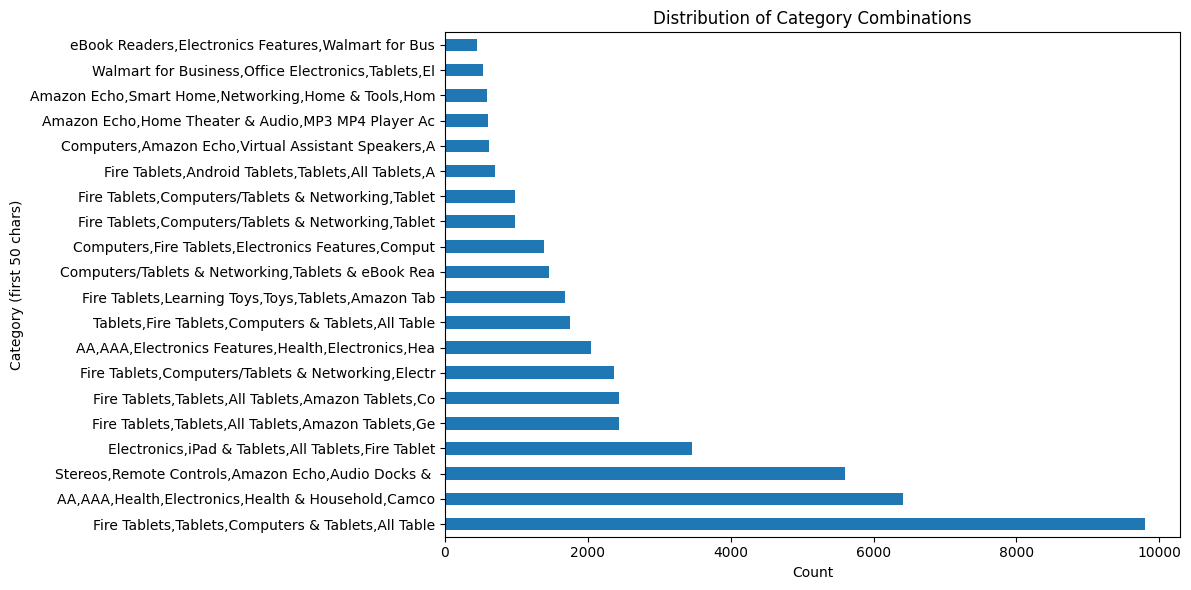

In [28]:
# Check categories balance, how many reviews are there per category
category_counts = data['categories'].value_counts()

for category, count in category_counts.items():
    print(f"{category[:50]}: {count}")

# Plot the distribution with inverted axes
plt.figure(figsize=(12, 6))
cat_filter = 20
bars = category_counts[:cat_filter].plot(kind='barh')
plt.title('Distribution of Category Combinations')
plt.ylabel('Category (first 50 chars)')
plt.xlabel('Count')

# Update the y-axis labels to show only the first 50 characters
bars.set_yticklabels([cat[:50] for cat in category_counts.index[:cat_filter]])

plt.tight_layout()
plt.show()


The amount of reviews per category is highly unbalanced. We need to group them as best as possible to balanced sub categories

## Model choice



In [34]:
# initialise model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# create corpus
corpus = data['categories'].unique().tolist()
print(len(corpus), 'unique categories')

# Generate embeddings
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

# Use SentenceTransformer's built-in clustering with hierarchical clustering
clusters = util.community_detection(corpus_embeddings, min_community_size=2, threshold=0.5)

print(clusters)

# prit clustering results
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} categories")

88 unique categories
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 78, 79, 80, 81, 82, 83, 84, 85, 87], [9, 74, 86], [75, 77]]
Cluster 0: 81 categories
Cluster 1: 3 categories
Cluster 2: 2 categories


In [35]:
# Organize clustered categories
clustered_categories = []
for cluster in clusters:
    clustered_categories.append([corpus[i] for i in cluster])

# Dictionary to store the most common words for each cluster
cluster_words = {}

# ignore some recurrent words
ignored_words = ['Amazon']

# Process each cluster
for i, cluster in enumerate(clustered_categories):

    # Clean and prepare the cluster text
    clean_cluster = re.sub(r'[^A-Za-z0-9\s]', '', " ".join(cluster))
    all_words = [word.strip() for word in clean_cluster.split()]

    # Count frequency of each word and get top 10
    word_counts = Counter(all_words)
    for word in ignored_words:
        if word in word_counts:
            del word_counts[word]
    most_common_words = word_counts.most_common(10)

    # Store the results in the dictionary
    cluster_words[f"Cluster {i}"] = most_common_words

    # Print results for inspection
    print(f"CLUSTER {i}:")
    for word, count in most_common_words:
        print(f"{word} ({count})")
    print(SEP)

CLUSTER 0:
Device (32)
Home (31)
Fire (24)
eBook (20)
TabletsAmazon (19)
Tablets (16)
Audio (14)
Adapters (13)
Book (12)
Readers (12)
----------------------------------------------------------------------------------------------------
CLUSTER 1:
SuppliesPet (4)
KennelsPet (2)
StoresDog (2)
SuppliesTop (2)
Selection (2)
from (2)
Crate (1)
TrainingCrates (1)
SuppliesDogsCity (1)
SniffersCustom (1)
----------------------------------------------------------------------------------------------------
CLUSTER 2:
Smart (4)
Audio (2)
Home (2)
Speakers (2)
EchoSee (1)
more (1)
Echo (1)
1st (1)
Generation (1)
Assistant (1)
----------------------------------------------------------------------------------------------------


## Plot clustering results

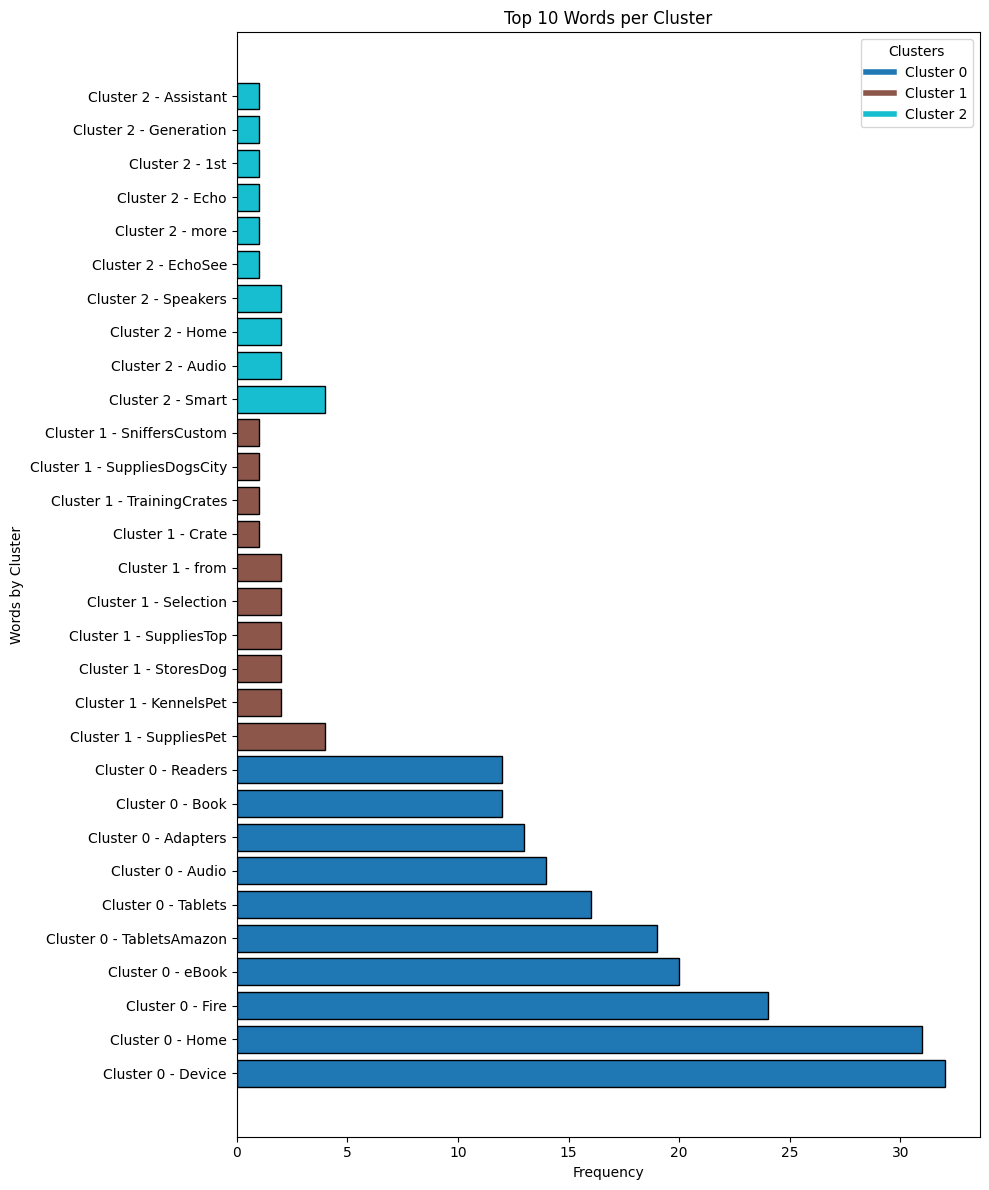

In [36]:
# Generate distinct colors for each cluster
colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_words)))

# Prepare data for plotting
words = []
counts = []
color_map = []
cluster_labels = []

for idx, (cluster, word_count_list) in enumerate(cluster_words.items()):
    for word, count in word_count_list:
        words.append(f"{cluster} - {word}")
        counts.append(count)
        color_map.append(colors[idx])
        cluster_labels.append(cluster)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(words, counts, color=color_map, edgecolor="black")

# Legend
legend_labels = [f"Cluster {i}" for i in range(len(cluster_words))]
unique_colors = [colors[i] for i in range(len(cluster_words))]
custom_legend = [plt.Line2D([0], [0], color=unique_colors[i], lw=4) for i in range(len(unique_colors))]
plt.legend(custom_legend, legend_labels, title="Clusters", loc="upper right")

# Labels and title
plt.ylabel("Words by Cluster")
plt.xlabel("Frequency")
plt.title("Top 10 Words per Cluster")

plt.tight_layout()
plt.show()

In [32]:
# Calculate silhouette score
silhouette_avg = silhouette_score(corpus_embeddings, clustering_model.labels_)
print(f'Silhouette Score: {silhouette_avg:.4f}')


NameError: name 'corpus_embeddings' is not defined

A silhouette score of 0.2389 indicates that the clusters are somewhat loosely defined, meaning there may be overlapping clusters or that some data points are not well-separated from others.

In [17]:
db_index = davies_bouldin_score(corpus_embeddings, clustering_model.labels_)
ch_score = calinski_harabasz_score(corpus_embeddings, clustering_model.labels_)

print(f'Davies-Bouldin Index: {db_index}')
print(f'Calinski-Harabasz Index: {ch_score}')


Davies-Bouldin Index: 1.6767922571334957
Calinski-Harabasz Index: 15.392633638726066


The Davies-Bouldin Index indicates there is some separation but not strong compactness within clusters.

The Calinski-Harabasz Index being low supports this, pointing to possible overlap between clusters or diffuse clustering boundaries.

## Visualise clustering results
Let's use t-SNE to visualise our clusters once we reduce the results to 2 dimensions

In [37]:
# Step 1: Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(corpus_embeddings)

# Step 2: Get cluster labels from your clustering model
cluster_labels = clustering_model.labels_

# Define colors for each cluster
num_clusters = len(set(cluster_labels))
colors = plt.cm.get_cmap("tab10", num_clusters)

# Step 3: Plot each cluster with a different color
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    indices = np.where(cluster_labels == cluster)
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        label=f"Cluster {cluster + 1}",
        cmap=colors,
        alpha=0.7,
        s=50
    )

plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


The t-SNE visualization shows fairly well-separated clusters, which is a positive sign that the KMeans clustering worked effectively.

Most clusters are well-separated, with distinct groupings for clusters 1, 2, and 6 in particular. This indicates that embeddings and clustering configuration captured meaningful differences between these categories.

Clusters 1, 2, and 6 appear more compact, suggesting strong cohesion within those groups.

Clusters 3 and 4 are a bit more spread out, which might reflect more internal variability within those categories.

There is minimal overlap between clusters, which is a positive sign for a clean segmentation of categories.

Cluster 4 is slightly closer to clusters 1 and 3, but they’re still visually distinguishable, so this isn’t necessarily an issue.

## Let's rename our clusters and add them to the dataset

In [18]:
# manually assigning names to each cluster
cluster_names = {
    0: "Electronics & Media",
    1: "Tablets & eReaders",
    2: "Accessories & Adapters",
    3: "Home & Smart Devices",
    4: "Pet Supplies",
    5: "Video & Streaming"
}

# clustering the corpus: each category receives a cluster name
clustered_corpus = {}
for i, cat in enumerate(corpus):
    clustered_corpus[cat] = cluster_names[cluster_assignment[i]]

# update dataset with a new column
data_clustered = data.copy()
data_clustered['clusterCategories'] = data_clustered['categories'].map(clustered_corpus)

# drop othe categories column
data_clustered.drop('categories', axis=1, inplace=True)

print(data_clustered.info())
data_clustered.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59079 entries, 0 to 59078
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               59079 non-null  object 
 1   brand              59079 non-null  object 
 2   reviews.rating     59047 non-null  float64
 3   review             50174 non-null  object 
 4   clusterCategories  59079 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.3+ MB
None


,name,brand,reviews.rating,review,clusterCategories
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Great device for reading. Definately pricey.\n...,Electronics & Media
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,"Excellent Kindle\nThe best Kindle ever, for me...",Electronics & Media
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,Love it\nI absolutely love this reader. The bi...,Electronics & Media
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Good kindle\nI always use it when i read ebook...,Electronics & Media
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,"So much to love, but slippery\nLove bigger scr...",Electronics & Media
5,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,Expensive but nice\nI was used to the Kindle 3...,Electronics & Media
6,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,Like it\nI love this so far only downside is y...,Electronics & Media
7,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Love it!\nI adore this kindle. I have owned vo...,Electronics & Media
8,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,"You get what you pay for\nBest reader, super l...",Electronics & Media
9,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Best Kindle ever....\nThis is the best Kindle ...,Electronics & Media


In [19]:
helpers.print_random_product_sheet(data_clustered)

----------------------------------------------------------------------------------------------------
[name] Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta
----------------------------------------------------------------------------------------------------
[brand] Amazon
----------------------------------------------------------------------------------------------------
[reviews.rating] 4.0
----------------------------------------------------------------------------------------------------
[review] Great tablet. Bought for my Kids
Very impressed with this tablet. I usually only purchase Samsung products but I needed something affordable for my children that wasn't terrible like the other knock off brands. This tablet is fast. Needs me memory but it is perfect for my kids. I bought 4!!!
----------------------------------------------------------------------------------------------------
[clusterCategories] Tablets & eReaders


## Pickle categorized dataset

In [20]:
data_clustered.to_pickle('pickle/data_clustered.pkl')